# Faostat global model
In this notebook we create an ensemble of multilayer perceptron ([MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) models to fit the world crop yields using the input variables: precipitation, air temperature, natural and synthetic fertilizers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## The dataset
We load the dataset that was prepared by putting into the same file the predictors and the predictands data

In [2]:
global_crop_yield_path = 'data/global_dataset.csv'
global_crop_yield_df = pd.read_csv(global_crop_yield_path, index_col=0)
global_crop_yield_df.head(2)

,Maize (100g/ha),Millet (100g/ha),Temp. Anom. (°C),Prec.Anom. (mm),CO2 (ppm),Manure (Mt),Nitrogen (tons),Phosphate (tons),Potash (tons)
1961-12-31,19423,5925,0.211,15.318908,317.64,1.835092e+10,11486265.27,10888968.81,8626724.57
1962-12-31,19796,5619,0.038,0.768900,318.45,1.872918e+10,12969831.11,11534554.43,9146891.38


## Data preparation
Since the values for the variables differ by orders of magnitude, we normalize them before using the data as input for the model. We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from the scikit-learn package to normalize the values. The scaler removes the mean and scale the values to unit variance. We start by selecting the columns with the input data

In [28]:
X = global_crop_yield_df.iloc[:, [2, 3, 4, 5, 6]].to_numpy()
y = global_crop_yield_df.iloc[:, [0]].to_numpy()

and the column of the predictand (maize)

In [29]:
y[:1]

array([[19423]], dtype=int64)

In [30]:
from sklearn import preprocessing
scaler_x = preprocessing.StandardScaler().fit(X)

The scaler computes the mean of the input variables

In [31]:
mean_x = scaler_x.mean_[0]
mean_x

0.5707741935483871

and the variance

In [32]:
variance_x = scaler_x.scale_[0]
variance_x

0.5387043721971724

we use the scaler to normalize the input variables

In [61]:
X_scaled = scaler_x.transform(X)
X_scaled.shape

(62, 5)

In [64]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(62, 1)

In [35]:
mean_y = scaler_y.mean_[0]
mean_y

38951.403225806454

In [36]:
variance_y = scaler_y.scale_[0]
variance_y

11966.558404448891

## Train and test set
The data used to train a model of the ensemble is divided into a train set and a test set

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55, 5), (55, 1), (7, 5), (7, 1))

## Ensemble models training

In [37]:
num_observations = X.shape[0]
num_observations

62

We train an ensemble of MLP models that start with a different init parameters

In [38]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

A random state is the seed used during the training of a model of the ensemble

In [39]:
random_states[:]

[2, 53, 22, 29, 24, 62, 18, 40, 13, 48, 25, 14, 43, 4, 54, 35, 4, 29, 50, 60]

We initialize a 2D array that will contain the predictions of the ensemble models

In [58]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(62, 20)

In [67]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(5, ),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs'
            )
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Ensemble {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}\n")

Ensemble 0
done in 0.178s
Train R2 score: 0.99
Test R2 score: 0.96

Ensemble 1
done in 0.116s
Train R2 score: 0.99
Test R2 score: 0.87

Ensemble 2
done in 0.071s
Train R2 score: 0.99
Test R2 score: 0.92

Ensemble 3
done in 0.086s
Train R2 score: 0.99
Test R2 score: 0.94

Ensemble 4
done in 0.075s
Train R2 score: 0.99
Test R2 score: 0.98

Ensemble 5
done in 0.117s
Train R2 score: 0.99
Test R2 score: 0.97

Ensemble 6
done in 0.136s
Train R2 score: 0.99
Test R2 score: 0.86

Ensemble 7
done in 0.068s
Train R2 score: 0.99
Test R2 score: 0.83

Ensemble 8
done in 0.065s
Train R2 score: 0.99
Test R2 score: 0.98

Ensemble 9
done in 0.068s
Train R2 score: 0.99
Test R2 score: 0.98

Ensemble 10
done in 0.117s
Train R2 score: 0.99
Test R2 score: 0.97

Ensemble 11
done in 0.074s
Train R2 score: 0.99
Test R2 score: 0.97

Ensemble 12
done in 0.079s
Train R2 score: 0.99
Test R2 score: 0.91

Ensemble 13
done in 0.093s
Train R2 score: 0.99
Test R2 score: 0.90

Ensemble 14
done in 0.077s
Train R2 score: 1

In [68]:
len(ensemble_members[:,0])

62

## Inverse transform
We denormalize the predictions by inverting the predicted values. We can perform the inverse transform using a simple equation

In [69]:
ensemble_denorm = ensemble_members * variance_y + mean_y
ensemble_denorm[:,0]

array([17123.42945091, 20191.69979334, 20815.87219846, 19885.68487431,
       21068.96787828, 21974.90105063, 23706.47108454, 23240.07960253,
       23436.6321618 , 23858.60805756, 25359.69391509, 26933.77083644,
       26465.55544665, 26039.44222612, 29066.39848047, 29474.9129364 ,
       31095.61608087, 30616.98918762, 32518.62861003, 31982.78965238,
       33022.25011731, 35952.38760631, 31721.29647342, 34350.57465342,
       36921.61205035, 35822.4664161 , 34600.68898075, 32358.91999432,
       36357.97979038, 36034.95373904, 37746.68641066, 38475.00612399,
       39051.92444916, 39015.40113672, 36896.6290209 , 38237.64692617,
       39597.20688414, 44232.09981186, 44852.3743559 , 43334.21400196,
       44874.10218357, 45163.15869126, 45965.9914885 , 47138.35641441,
       47662.45950905, 48943.73333802, 49121.72914633, 49112.90025241,
       49070.01997768, 51114.08165613, 50982.91394278, 51753.19074425,
       53227.09116272, 53546.20282072, 54792.10101926, 57762.32913146,
      

or we can use the function provided by the scaler

In [72]:
prediction = scaler_y.inverse_transform(ensemble_members)
best_model_predictions = prediction[:,4]

## Best ensemble model visualization
We use the ensemble 16 with the best test R2 score

In [71]:
#model_sample_best = predictions_denorm.iloc[:, 16]
#model_sample_best[:2]

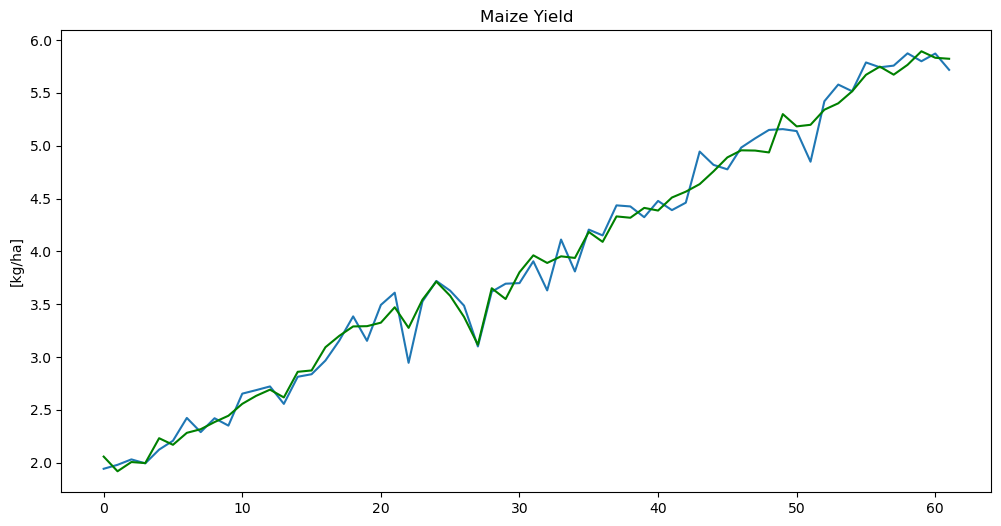

In [75]:
from matplotlib import dates
import matplotlib.dates as mdates

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
#ax.grid(True, which='both')
#ax.set_xticks(predictions_denorm.index)
#ax.set_xticklabels(predictions_denorm.index, rotation=70)
#ax.xaxis.set_major_locator(dates.YearLocator(5))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#maize_yield = global_crop_yield_df['Maize (100g/ha)'] / 10000 
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
pd_predictions_best, = plt.plot(best_model_predictions / 10000, label='Best Predictions', color='green')
#plt.legend(handles=[pd_maize_yield, pd_predictions_best], loc='upper left')